<a href="https://colab.research.google.com/github/marcellobeer/arxiv-classification/blob/main/arxiv_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Install required packages
!pip install arxiv transformers tqdm

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 2.9 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6047 sha256=7c228f143ed49b193bf9f16959ad8fc7d7693b56dbc76fbfd6f4184f8bb5e443
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built sgmllib3k


In [5]:
import arxiv
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import time
from tqdm import tqdm
import pickle
%matplotlib inline


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [11]:
# Function to load files from GitHub
def load_from_github(file_name):
    url = f"https://raw.githubusercontent.com/your_username/arxiv-classification/main/{file_name}"
    response = requests.get(url)
    if response.status_code == 200:
        if file_name.endswith('.pkl'):
            return pickle.loads(response.content)
        elif file_name.endswith('.npy'):
            return np.load(response.content)
        else:
            return response.content.decode('utf-8')  # For text files
    else:
        print(f"Error loading {file_name} from GitHub: {response.status_code}")
        return None

In [12]:
   def save_to_github(file_path):
       try:
           os.system(f'git add {file_path}')
           os.system('git commit -m "Update data files"')
           os.system('git push')
       except Exception as e:
           print(f"Error saving to GitHub: {e}")

In [13]:
# Configs
class Config:
    MODEL_NAME = 'allenai/scibert_scivocab_uncased'
    MAX_LENGTH = 512
    BATCH_SIZE = 8
    TEST_SIZE = 0.2
    RANDOM_SEED = 42

    # Physics categories
    CATEGORIES = {
        'astro-ph': 'Astrophysics',
        'cond-mat': 'Condensed Matter',
        'gr-qc': 'General Relativity and Quantum Cosmology',
        'hep-ex': 'High Energy Physics - Experiment',
        'hep-lat': 'High Energy Physics - Lattice',
        'hep-ph': 'High Energy Physics - Phenomenology',
        'hep-th': 'High Energy Physics - Theory',
        'math-ph': 'Mathematical Physics',
        'nucl-ex': 'Nuclear Experiment',
        'nucl-th': 'Nuclear Theory',
        'physics': 'Physics (misc.)',
        'quant-ph': 'Quantum Physics'
    }

In [14]:
# Data Collection - Fetch papers from arXiv for physics categories
def fetch_papers(max_results_per_category=1000):
    client = arxiv.Client()
    all_papers = []

    for category in tqdm(Config.CATEGORIES.keys()):
        try:
            search = arxiv.Search(
                query=f"cat:{category}",
                max_results=max_results_per_category,
                sort_by=arxiv.SortCriterion.SubmittedDate
            )
            results = client.results(search)

            for paper in results:
                paper_dict = {
                    'title': paper.title,
                    'abstract': paper.summary,
                    'category': category
                }
                all_papers.append(paper_dict)

            time.sleep(3)

        except Exception as e:
            print(f"Error fetching category {category}: {str(e)}")
            continue

    return pd.DataFrame(all_papers)

In [15]:
# Data Collection and Initial Exploration
print("Loading saved papers from pickle file...")
try:
    df = pd.read_pickle('physics_papers.pkl')
    print(f"Successfully loaded {len(df)} papers from saved file.")
except FileNotFoundError:
    print("Saved file not found. Fetching papers from arXiv...")
    df = fetch_papers(max_results_per_category=1000)
    # Save the data
    df.to_pickle('physics_papers.pkl')

Loading saved papers from pickle file...
Successfully loaded 11000 papers from saved file.


In [16]:
# Datased checks
print("\nDataset Overview:")
print("-" * 50)
print(f"Total papers: {len(df)}")
print("\nPapers per category:")
print(df['category'].value_counts())


Dataset Overview:
--------------------------------------------------
Total papers: 11000

Papers per category:
category
astro-ph    1000
cond-mat    1000
gr-qc       1000
hep-ex      1000
hep-lat     1000
hep-ph      1000
hep-th      1000
math-ph     1000
nucl-ex     1000
nucl-th     1000
quant-ph    1000
Name: count, dtype: int64


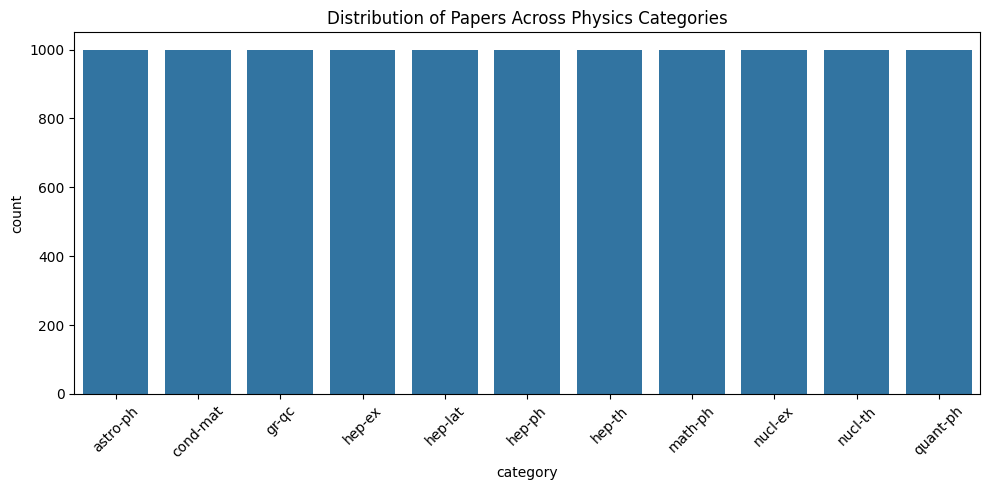

In [17]:
# Distribution of papers across categories
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='category')
plt.title('Distribution of Papers Across Physics Categories')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
# Sample
print("\nSample Paper:")
print("-" * 50)
sample_idx = np.random.randint(len(df))
print(f"Title: {df.iloc[sample_idx]['title']}")
print(f"Category: {df.iloc[sample_idx]['category']} ({Config.CATEGORIES[df.iloc[sample_idx]['category']]})")
print(f"\nAbstract snippet: {df.iloc[sample_idx]['abstract'][:300]}...")


Sample Paper:
--------------------------------------------------
Title: Simulating black hole quantum dynamics on an optical lattice using the complex Sachdev-Ye-Kitaev model
Category: gr-qc (General Relativity and Quantum Cosmology)

Abstract snippet: We propose a low energy model for simulating an analog black hole on an
optical lattice using ultracold atoms. Assuming the validity of the holographic
principle, we employ the Sachdev-Ye-Kitaev (SYK) model, which describes a
system of randomly infinite range interacting fermions, also conjectured t...


In [19]:
# Dataset info
print("\nDataset Information:")
print("-" * 50)
print(df.info())


Dataset Information:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     11000 non-null  object
 1   abstract  11000 non-null  object
 2   category  11000 non-null  object
dtypes: object(3)
memory usage: 257.9+ KB
None


In [20]:
# Check missing values
print("\nMissing Values:")
print("-" * 50)
print(df.isnull().sum())


Missing Values:
--------------------------------------------------
title       0
abstract    0
category    0
dtype: int64


In [21]:
# Clean and preprocess text
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove LaTeX equations (text between $ or $$)
    text = re.sub(r'\$+[^$]*\$+', '', text)

    # Remove special characters but keep basic punctuation
    text = re.sub(r'[^A-Za-z0-9\s.,!?-]', '', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    return text

In [22]:
# Combine title and abstract for full text representation
print("Preprocessing text...")
df['text'] = df['title'] + " " + df['abstract']
df['processed_text'] = df['text'].apply(preprocess_text)

Preprocessing text...


In [23]:
# Initialize SciBERT
print("Loading SciBERT...")
tokenizer = AutoTokenizer.from_pretrained(Config.MODEL_NAME)
model = AutoModel.from_pretrained(Config.MODEL_NAME).to(device)

Loading SciBERT...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

In [24]:
import os
# Generate SciBERT embeddings for a list of texts
def get_embeddings(texts, batch_size=64):  # Increased batch size
    # Check cache first
    cache_file = 'embeddings_cache.npy'
    if os.path.exists(cache_file):
        print("Loading cached embeddings...")
        return np.load(cache_file)

    print("Generating new embeddings...")

    # Move model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    print(f"Using device: {device}")

    # Pre-calculate total number of batches for tqdm
    total_batches = len(range(0, len(texts), batch_size))

    # Initialize list with known final size for better memory efficiency
    embeddings = []

    for i in tqdm(range(0, len(texts), batch_size), total=total_batches, desc="Generating embeddings"):
        batch_texts = texts[i:i + batch_size]
        encoded = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=Config.MAX_LENGTH,
            return_tensors='pt'
        )

        # Move batch to GPU if available
        encoded = {k: v.to(device) for k, v in encoded.items()}

        with torch.no_grad():
            outputs = model(**encoded)
            # Move to CPU before converting to numpy
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.extend(batch_embeddings)

        # Clear CUDA cache periodically
        if device.type == 'cuda' and i % (batch_size * 10) == 0:
            torch.cuda.empty_cache()

    embeddings = np.array(embeddings)

    # Cache the results
    print("Saving embeddings to cache...")
    np.save(cache_file, embeddings)

    return embeddings

In [25]:
# Load or generate embeddings
print("Loading embeddings...")
try:
    embeddings = np.load('paper_embeddings.npy')
    print(f"Successfully loaded embeddings with shape {embeddings.shape}")
except FileNotFoundError:
    print("Saved embeddings not found. Generating new embeddings...")
    embeddings = get_embeddings(df['processed_text'].tolist())
    # Save the embeddings
    print("Saving embeddings...")
    np.save('paper_embeddings.npy', embeddings)

Loading embeddings...
Successfully loaded embeddings with shape (11000, 768)


In [26]:
# Display sample preprocessed text
print("\nSample Preprocessed Text:")
print("-" * 50)
print("Original:")
print(df.iloc[sample_idx]['text'][:200])
print("\nProcessed:")
print(df.iloc[sample_idx]['processed_text'][:200])


Sample Preprocessed Text:
--------------------------------------------------
Original:
Simulating black hole quantum dynamics on an optical lattice using the complex Sachdev-Ye-Kitaev model We propose a low energy model for simulating an analog black hole on an
optical lattice using ult

Processed:
Simulating black hole quantum dynamics on an optical lattice using the complex Sachdev-Ye-Kitaev model We propose a low energy model for simulating an analog black hole on an optical lattice using ult


In [27]:
# Display embedding shape
print("\nEmbedding Shape:", embeddings.shape) # Should be (num_papers, 768) for SciBERT


Embedding Shape: (11000, 768)


## Classifying papers into categories

In [28]:
# Split Data and Train Classifier
print("Preparing data for classification...")
X = embeddings   # Our features (paper embeddings)
y = df['category']  # Our labels (paper categories)

# Convert category names to numbers (e.g., 'astro-ph' → 0)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=Config.TEST_SIZE,
    random_state=Config.RANDOM_SEED,
    stratify=y_encoded
)

Preparing data for classification...


In [29]:
# 1. Compare Multiple Classifiers
print("\nComparing Different Classifiers:")
print("-" * 50)

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

# Scale the features for better neural network performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

classifiers = {
    'Logistic Regression': LogisticRegression(
        max_iter=2000,  # Reduced iterations
        C=0.1,
        class_weight='balanced',
        random_state=Config.RANDOM_SEED,
        n_jobs=-1  # Use all cores for faster training
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,  # Further reduced estimators
        max_depth=20,      # Reduced depth
        min_samples_split=5,
        class_weight='balanced',
        n_jobs=-1,  # Use all cores in Colab
        random_state=Config.RANDOM_SEED
    ),
    'Neural Network': MLPClassifier(
        hidden_layer_sizes=(256, 128),  # Simplified architecture
        max_iter=1000,     # Reduced iterations
        early_stopping=True,
        validation_fraction=0.1,
        learning_rate='adaptive',
        random_state=Config.RANDOM_SEED
    )
}

# Train and evaluate each classifier
results = {}
best_classifier = None
best_cv_score = 0

# Use fewer CV folds
N_FOLDS = 3  # Reduced from 5

for name, clf in classifiers.items():
    print(f"\nTraining {name}...")

    # Use scaled data for Neural Network, raw data for others
    if name == 'Neural Network':
        X_train_current = X_train_scaled
        X_test_current = X_test_scaled
        X_cv = X_scaled
    else:
        X_train_current = X_train
        X_test_current = X_test
        X_cv = X

    # Fit the model
    clf.fit(X_train_current, y_train)

    # Get predictions and accuracy
    y_pred = clf.predict(X_test_current)
    accuracy = accuracy_score(y_test, y_pred)

    # Perform cross-validation with fewer folds
    cv_scores = cross_val_score(clf, X_cv, y_encoded, cv=N_FOLDS)
    avg_cv_score = cv_scores.mean()

    # Store results
    results[name] = {
        'accuracy': accuracy,
        'cv_score': avg_cv_score,
        'cv_std': cv_scores.std()
    }

    print(f"{name} Test Accuracy: {accuracy:.4f}")
    print(f"{name} CV Score: {avg_cv_score:.4f} (+/- {cv_scores.std() * 2:.4f})")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    if avg_cv_score > best_cv_score:
        best_cv_score = avg_cv_score
        best_classifier = clf
        best_name = name

# Print final results
print("\nFinal Results:")
print("-" * 50)
for name, metrics in results.items():
    print(f"{name}:")
    print(f"  Test Accuracy: {metrics['accuracy']:.4f}")
    print(f"  CV Score: {metrics['cv_score']:.4f} (+/- {metrics['cv_std'] * 2:.4f})")

print(f"\nBest Model: {best_name}")
print(f"Best Cross-Validation Score: {best_cv_score:.4f}")


Comparing Different Classifiers:
--------------------------------------------------

Training Logistic Regression...
Logistic Regression Test Accuracy: 0.5386
Logistic Regression CV Score: 0.5544 (+/- 0.0196)

Classification Report:
              precision    recall  f1-score   support

    astro-ph       0.82      0.82      0.82       200
    cond-mat       0.75      0.76      0.75       200
       gr-qc       0.51      0.52      0.52       200
      hep-ex       0.43      0.43      0.43       200
     hep-lat       0.58      0.65      0.61       200
      hep-ph       0.32      0.30      0.31       200
      hep-th       0.37      0.33      0.35       200
     math-ph       0.61      0.66      0.63       200
     nucl-ex       0.41      0.41      0.41       200
     nucl-th       0.36      0.33      0.34       200
    quant-ph       0.70      0.71      0.71       200

    accuracy                           0.54      2200
   macro avg       0.53      0.54      0.54      2200
weighted

In [31]:
# 3. Error Analysis
print("\nPerforming Error Analysis:")
print("-" * 50)

def analyze_errors(y_true, y_pred, df, test_indices, label_encoder):
    """Analyze misclassified papers"""
    mistakes = y_true != y_pred
    error_indices = np.where(mistakes)[0]

    print(f"\nTotal errors: {len(error_indices)}")
    print("\nSample of misclassified papers:")
    for idx in error_indices[:5]:  # Show first 5 errors
        print("\n" + "="*50)
        print(f"Predicted: {label_encoder.inverse_transform([y_pred[idx]])[0]}")
        print(f"Actual: {label_encoder.inverse_transform([y_true[idx]])[0]}")
        print(f"\nTitle: {df['title'].iloc[test_indices[idx]]}")
        print(f"\nAbstract snippet: {df['abstract'].iloc[test_indices[idx]][:200]}...")

# Keep track of indices during train_test_split
indices = np.arange(len(X))
X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
    X, y_encoded, indices,
    test_size=Config.TEST_SIZE,
    random_state=Config.RANDOM_SEED,
    stratify=y_encoded
)

# Get predictions from best classifier
y_pred_best = best_classifier.predict(X_test)
analyze_errors(y_test, y_pred_best, df, test_idx, label_encoder)

# Save best model
print("\nSaving best model...")
model_data = {
    'classifier': best_classifier,
    'label_encoder': label_encoder,
    'config': Config,
    'comparison_results': results
}
with open('physics_classifier.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print("\nClassification analysis complete!")


Performing Error Analysis:
--------------------------------------------------

Total errors: 1015

Sample of misclassified papers:

Predicted: hep-lat
Actual: nucl-th

Title: Effects of threshold resummation for large-$x$ PDF in large momentum effective theory

Abstract snippet: Parton distribution functions (PDFs) at large $x$ are challenging to extract
from experimental data, yet they are essential for understanding hadron
structure and searching for new physics beyond the ...

Predicted: nucl-ex
Actual: hep-ex

Title: Global Extraction of the $\rm^{12}C$ Nuclear Electromagnetic Response Functions (${\cal R}_L$ and ${\cal R}_T$) and Comparisons to Nuclear Theory and Neutrino/Electron Monte Carlo Generators

Abstract snippet: We have performed a global extraction of the ${\rm ^{12}C}$ longitudinal
(${\cal R}_L$) and transverse (${\cal R}_T$) nuclear electromagnetic response
functions from an analysis of all available elect...

Predicted: hep-ph
Actual: hep-th

Title: A functional tre

## Based on one paper, find similar ones

In [34]:
# 2. Similarity Search Function
def find_similar_papers(query_idx, top_k=5):
    # Find similar papers given a query paper index
    query_embedding = embeddings[query_idx]

    # Compute cosine similarity
    similarities = np.dot(embeddings, query_embedding) / (
        np.linalg.norm(embeddings, axis=1) * np.linalg.norm(query_embedding)
    )

    # Get top k similar papers (excluding the query paper itself)
    similar_indices = np.argsort(similarities)[-top_k-1:-1][::-1]

    return df.iloc[similar_indices], similarities[similar_indices]

In [35]:
# Test similarity search
print("\nTesting Similarity Search:")
print("-" * 50)
sample_idx = np.random.randint(len(df))
print(f"Query Paper: {df.iloc[sample_idx]['title']}")
print(f"Category: {df.iloc[sample_idx]['category']}")


Testing Similarity Search:
--------------------------------------------------
Query Paper: Kondo lattice model with a direct exchange interaction between localized moments
Category: cond-mat


In [36]:
similar_papers, similarities = find_similar_papers(sample_idx)
print("\nMost Similar Papers:")
for i, (_, paper) in enumerate(similar_papers.iterrows()):
    print(f"\n{i+1}. {paper['title']}")
    print(f"Category: {paper['category']}")
    print(f"Similarity: {similarities[i]:.4f}")


Most Similar Papers:

1. Effects of disorder in two-dimensional quantum antiferromagnets
Category: cond-mat
Similarity: 0.9251

2. Resonance Kondo Tunneling through a Double Quantum Dot at Finite Bias
Category: cond-mat
Similarity: 0.9231

3. Two-particle localization and antiresonance in disordered spin and qubit chains
Category: cond-mat
Similarity: 0.9207

4. The effect of charm quark on chiral phase transition in $N_f=2+1+1$ holographic QCD
Category: hep-lat
Similarity: 0.9170

5. Jost solutions and quantum conserved quantities of an integrable derivative nonlinear Schrodinger model
Category: cond-mat
Similarity: 0.9163


## Saving everything


In [37]:
# Save trained model and encoders
print("\nSaving model and encoders...")
model_data = {
    'classifier': best_classifier,  # Changed from classifier to best_classifier
    'label_encoder': label_encoder,
    'config': Config
}
with open('physics_classifier.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print("Done! All components are ready for the Streamlit interface.")


Saving model and encoders...
Done! All components are ready for the Streamlit interface.


In [38]:
# Save all required files
files_to_save = {
    'model': 'physics_classifier.pkl',
    'embeddings': 'paper_embeddings.npy',
    'papers': 'papers_df.pkl'
}

with open(files_to_save['model'], 'wb') as f:
    pickle.dump({
        'classifier': best_classifier,
        'label_encoder': label_encoder
    }, f)

np.save(files_to_save['embeddings'], embeddings)
df.to_pickle(files_to_save['papers'])

In [39]:
!pip install streamlit pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.6 MB/s eta 0:00:00


In [40]:
# Set your auth token (only needs to be done once per session)
!ngrok authtoken 2oqSlpFa6kknymol15javDQcrCG_6zyZgBaCBLiQa1cE97goQ

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [41]:
from pyngrok import ngrok

# Start ngrok tunnel on localhost port 8501 for the Streamlit app
public_url = ngrok.connect("http://localhost:8501")
print(f"Streamlit app URL: {public_url}")

Streamlit app URL: NgrokTunnel: "https://231b-34-23-64-22.ngrok-free.app" -> "http://localhost:8501"


In [48]:
%%writefile streamlit_app.py
import streamlit as st
import pickle
import os
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel

# Configuration class
class Config:
    """Configuration parameters for the application"""
    MODEL_NAME = 'allenai/scibert_scivocab_uncased'
    MAX_LENGTH = 512
    BATCH_SIZE = 8
    TEST_SIZE = 0.2
    RANDOM_SEED = 42

    # Physics categories
    CATEGORIES = {
        'astro-ph': 'Astrophysics',
        'cond-mat': 'Condensed Matter',
        'gr-qc': 'General Relativity and Quantum Cosmology',
        'hep-ex': 'High Energy Physics - Experiment',
        'hep-lat': 'High Energy Physics - Lattice',
        'hep-ph': 'High Energy Physics - Phenomenology',
        'hep-th': 'High Energy Physics - Theory',
        'math-ph': 'Mathematical Physics',
        'nucl-ex': 'Nuclear Experiment',
        'nucl-th': 'Nuclear Theory',
        'quant-ph': 'Quantum Physics'
    }

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

@st.cache_resource
def load_resources():
    """Load or create all necessary resources for the app"""

    # Initialize tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(Config.MODEL_NAME)
    model = AutoModel.from_pretrained(Config.MODEL_NAME)
    model = model.to(device)
    model.eval()

    try:
        # Try to load existing data
        with open('physics_classifier.pkl', 'rb') as f:
            model_data = pickle.load(f)
        embeddings = np.load('paper_embeddings.npy')
        papers_df = pd.read_pickle('papers_df.pkl')

    except (FileNotFoundError, EOFError):
        try:
            # Try loading from GitHub if local files not found
            model_data = load_from_github('physics_classifier.pkl')
            embeddings = load_from_github('paper_embeddings.npy')
            papers_df = load_from_github('papers_df.pkl')

            if model_data is None or embeddings is None or papers_df is None:
                # If still not found, fetch data and generate files
                print("Fetching data and generating files...")
                papers_df = fetch_papers(max_results_per_category=1000)
                embeddings = get_embeddings(papers_df['processed_text'].tolist())

                # Train the model and save data
                model_data = train_models(embeddings, papers_df)

                # Save locally
                papers_df.to_pickle('papers_df.pkl')
                np.save('paper_embeddings.npy', embeddings)
                with open('physics_classifier.pkl', 'wb') as f:
                    pickle.dump(model_data, f)

        except Exception as e:
            print(f"Error loading from GitHub: {e}")
            # Generate new data if GitHub loading fails
            papers_df = fetch_papers(max_results_per_category=1000)
            embeddings = get_embeddings(papers_df['processed_text'].tolist())
            model_data = train_models(embeddings, papers_df)

    return model_data, embeddings, papers_df, tokenizer, model

def get_embedding(text, tokenizer, model):
    encoded = tokenizer(
        text,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors='pt'
    )
    with torch.no_grad():
        outputs = model(**encoded)
        return outputs.last_hidden_state[:, 0, :].numpy()[0]

def find_similar_papers(query_embedding, embeddings, papers_df, top_k=5):
    similarities = np.dot(embeddings, query_embedding) / (
        np.linalg.norm(embeddings, axis=1) * np.linalg.norm(query_embedding)
    )
    top_indices = np.argsort(similarities)[-top_k:][::-1]
    return papers_df.iloc[top_indices], similarities[top_indices]

# Page config
st.set_page_config(
    page_title="Physics Paper Analyzer",
    page_icon="📚",
    layout="wide"
)

# Main app
st.title('Physics Paper Analyzer 📚')
st.write('Enter a physics paper title and abstract to classify it and find similar papers.')

# Load resources
try:
    model_data, embeddings, papers_df, tokenizer, model = load_resources()
    classifier = model_data['classifier']
    label_encoder = model_data['label_encoder']
except ValueError as e:
    st.error(f"Error loading resources: {e}")
    st.stop()

# Input fields
abstract = st.text_area("Paper Abstract", height=150)

if st.button('Analyze Paper'):
    if abstract:
        with st.spinner('Analyzing paper...'):
            # Get embedding and predictions
            paper_embedding = get_embedding(abstract, tokenizer, model)
            prediction = classifier.predict([paper_embedding])[0]
            probabilities = classifier.predict_proba([paper_embedding])[0]

            # Classification Results
            st.subheader('Classification Results')
            predicted_category = label_encoder.inverse_transform([prediction])[0]
            st.markdown(f"### Predicted Category: `{predicted_category}`")

            # Plot probabilities
            prob_df = pd.DataFrame({
                'Category': label_encoder.classes_,
                'Probability': probabilities
            }).sort_values('Probability', ascending=True)
            st.bar_chart(prob_df.set_index('Category'))

            # Similar Papers
            st.subheader('Similar Papers')
            similar_papers, similarities = find_similar_papers(paper_embedding, embeddings, papers_df)

            for i, (_, paper) in enumerate(similar_papers.iterrows()):
                expander_title = f"{paper['title']}"
                with st.expander(expander_title, expanded=False):
                    st.markdown(f"**Category:** {paper['category']}")
                    st.markdown(f"**Similarity Score:** {similarities[i]:.4f}")
                    st.markdown("**Abstract:**")
                    st.markdown(paper['abstract'])
    else:
        st.warning('Please enter an abstract.')

Overwriting streamlit_app.py


In [49]:
!streamlit run streamlit_app.py &>/dev/null &
